In [4]:
import torch
from einops import rearrange, repeat
from torch import nn
import torch.nn.functional as F

In [7]:
MIN_NUM_PATCHES = 2

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


class MultiHeadDotProductAttention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim/heads) ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3)
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x1, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        queries = self.query(x1)
        keys = self.key(x)
        values = self.value(x)
        # q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        queries = rearrange(queries, 'b n (h d) -> b h (n d)', h=h)
        keys = rearrange(keys, 'b n (h d) -> b h (n d)', h=h)
        values = rearrange(values, 'b n (h d) -> b h (n d)', h=h)
        print('q :', queries.shape)
        dots = torch.einsum('bhid,bhjd->bhij', queries, keys) * self.scale
        print('dots:', dots.shape)

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
_shape, mlp_.dim, dropout_rate)
        self.drop_out_attention  = nn.Dropout(attention_dropout_rate)
    
    def forward(self, add_inputs, inputs):
        x1 = self.layer_norm_input(add_inputs)
        x = self.layer_norm_input(inputs)
        print('进入transformer前的x : ', x.shape)
        x = self.attention(x1,x)
        x = self.drop_out_attention(x)
        x = x + inputs
        y = self.layer_norm_out(x)
        print('拼接前的 y : ',y.shape)
        y = self.mlp(y)
        print('mlp后的y : ',y.shape)
        print('x+y : ', (x+y).shape)
        return x + y


class Encoder(nn.Module):
    def __init__(self, input_shape, num_layers, heads, mlp_dim, inputs_positions= None, dropout_rate=0.1, train=False):
        super().__init__()
        self.num_layers = num_layers 
        self.mlp_dim  = mlp_dim
        self.inputs_positions = inputs_positions
        self.dropout_rate = dropout_rate
        self.train_flag  = train
        self.encoder_norm = nn.LayerNorm(input_shape)
        # self.encoder_norm = nn.GroupNorm(1)
        self.layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([Encoder1DBlock(input_shape, heads, mlp_dim)]))

    def forward(self, img, img2, mask = None):
        x = img2
        x1 = img
        for layer in self.layers:
            x = layer[0](x1, x)
        return self.encoder_norm(x)


class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, depth, heads, mlp_dim, channels = 3, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        hidden_size = channels * patch_size ** 2
        assert num_patches > MIN_NUM_PATCHES, f'your number of patches ({num_patches}) is way too small for attention to be effective. try decreasing your patch size'

        self.patch_size = patch_size
        self.hidden_size = hidden_size
        self.embedding = nn.Conv2d(channels,hidden_size, patch_size, patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, hidden_size))
        # self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls = nn.Parameter(torch.randn(1, 1, hidden_size))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Encoder(hidden_size, depth, heads, mlp_dim, dropout_rate = dropout)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            # nn.Linear(hidden_size, 512),
            # nn.Linear(512, num_classes)
            nn.Linear(hidden_size,num_classes),
            nn.Softmax()
        )

    def forward(self, img, img2, mask = None):
        x1, x2 = self.embedding(img), self.embedding(img2)
        print('self.embedding: {}'.format(x1.shape))
        x1, x2 = rearrange(x1, 'b c h w  -> b (h w) c'), rearrange(x2, 'b c h w  -> b (h w) c')
        b, n, _ = x1.shape
        cls_tokens = repeat(self.cls, '() n d -> b n d', b = b)
        x1, x2 = torch.cat((cls_tokens, x1), dim=1), torch.cat((cls_tokens, x2), dim=1)
        print('self.embedding: {}'.format(x1.shape))
        x1 += self.pos_embedding[:, :(n + 1)]
        x2 += self.pos_embedding[:, :(n + 1)]
        x1 = self.dropout(x1)
        x2 = self.dropout(x2)
        print('self.embedding: {}'.format(x1.shape))
        x = self.transformer(x1,x2)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)
        return x


def VIT_B16_224(**kwargs):
    input_size = 16
    patch_size = 8
    num_layers = 1
    num_classes = 2
    if 'num_classes' in kwargs:
        num_classes = kwargs['num_classes']

    return ViT(
        image_size = input_size,
        patch_size = patch_size,
        num_classes = num_classes,
        depth = num_layers,
        heads = 1,
        mlp_dim = 64,
        dropout = 0.1,
        emb_dropout = 0.1
    )

In [8]:
input_size = 16
v = VIT_B16_224()
img = torch.randn(1, 3, input_size, input_size)
img2 = torch.randn(1, 3, input_size, input_size)
preds = v(img,img2) # (1, 1000)
# preds

self.embedding: torch.Size([1, 192, 2, 2])
self.embedding: torch.Size([1, 5, 192])
self.embedding: torch.Size([1, 5, 192])
进入transformer前的x :  torch.Size([1, 5, 192])


UnboundLocalError: local variable 'values' referenced before assignment

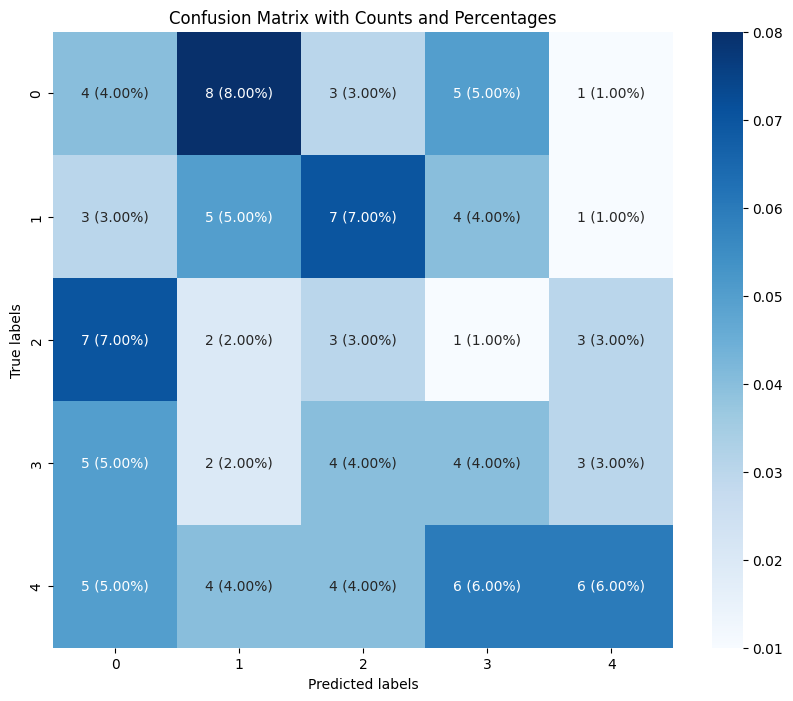

In [7]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 生成随机的分类标签数据
torch.manual_seed(42)
y_true = torch.randint(0, 5, size=(100,))
y_pred = torch.randint(0, 5, size=(100,))

# 计算混淆矩阵
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

# 计算每个单元格的数据量和百分比，并添加到混淆矩阵中
total_samples = np.sum(cm)
cm_with_stats = np.zeros_like(cm, dtype=float)
cm_annotations = []

for i in range(cm.shape[0]):
    row_stats = []
    for j in range(cm.shape[1]):
        count = cm[i, j]
        cm_with_stats[i, j] = count / total_samples  # 存储百分比而不是字符串
        row_stats.append(f'{count} ({(count / total_samples) * 100:.2f}%)')
    cm_annotations.append(row_stats)

# 绘制带有数据和百分比的混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm_with_stats, annot=np.array(cm_annotations), fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Counts and Percentages')
plt.show()

In [8]:
from mymodel.vit_model import VIT_B16_224

image_size = 224
height = int(image_size / (3686/850))+1

def print_model_layers(model):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Module):
            print(f"{name}")
            if len(list(module.children())) > 0:
                print_model_layers(module)
model = VIT_B16_224(num_classes = 2)

print_model_layers(model)
# class ReshapeTransform:
#     def __init__(self, model):
#         input_size = model.patch_embed.img_size
#         patch_size = model.patch_embed.patch_size
#         self.h = input_size[0] // patch_size[0]
#         self.w = input_size[1] // patch_size[1]

#     def __call__(self, x):# x是个token序列
#         # remove cls token and reshape
#         # [batch_size, num_tokens, token_dim]
#         #拿到所有组成原图的token，将它们reshape回原图的大小
#         result = x[:, 1:, :].reshape(x.size(0),#从1开始，忽略掉class_token
#                                      self.h,
#                                      self.w,
#                                      x.size(2))

#         # Bring the channels to the first dimension,
#         # like in CNNs.
#         # [batch_size, H, W, C] -> [batch, C, H, W]
#         result = result.permute(0, 3, 1, 2)
#         return result


# def main():
#     model = VIT_B16_224(num_classes = 2)
#     # 链接: https://pan.baidu.com/s/1zqb08naP0RPqqfSXfkB2EA  密码: eu9f
#     weights_path = "vit/kfold_model/m120.pth"
#     model.load_state_dict(torch.load(weights_path, map_location="cpu"))
#     target_layers = [model.blocks[-1].norm1] #最后一个block的norm1-
#     #---vit最后只对class_token做预测，只用它对结果有贡献，也就只有它有梯度，再将最后预测的结果进行反向传播，后面那几层都只是token自己的MLP,LN只有在多头注意力才将class_token与其余token关联起来
#     #反向梯度传播是从最后预测开始，经过整个模型。target_layers只是表示记录这些layers的梯度信息而已
#     data_transform = transforms.Compose([
#         transforms.Resize((image_size,height)),
#         transforms.Pad([int((image_size-height)/2),0],fill=(0,0,0),padding_mode='constant'),
#         # transforms.Resize((224, 224)), 
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
#     # load image
#     img_path = "prodata/test/nm/nm_0.jpg"
#     assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
#     img = Image.open(img_path).convert('RGB')
#     # [C, H, W]
#     img_tensor = data_transform(img)
#     # expand batch dimension
#     # [C, H, W] -> [N, C, H, W]
#     input_tensor = torch.unsqueeze(img_tensor, dim=0)

#     cam = GradCAM(model=model,
#                   target_layers=target_layers,
#                   use_cuda=False,
#                   reshape_transform=ReshapeTransform(model))
#     target_category = 281  # tabby, tabby cat
#     # target_category = 254  # pug, pug-dog

#     grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

#     grayscale_cam = grayscale_cam[0, :]
#     visualization = show_cam_on_image(img / 255., grayscale_cam, use_rgb=True)
#     plt.imshow(visualization)
#     plt.show()


# if __name__ == '__main__':
#     main()

embedding
dropout
transformer
encoder_norm
layers
0
0
layer_norm_input
layer_norm_out
attention
to_qkv
to_out
0
1
mlp
net
0
1
2
3
4
drop_out_attention
1
0
layer_norm_input
layer_norm_out
attention
to_qkv
to_out
0
1
mlp
net
0
1
2
3
4
drop_out_attention
2
0
layer_norm_input
layer_norm_out
attention
to_qkv
to_out
0
1
mlp
net
0
1
2
3
4
drop_out_attention
3
0
layer_norm_input
layer_norm_out
attention
to_qkv
to_out
0
1
mlp
net
0
1
2
3
4
drop_out_attention
4
0
layer_norm_input
layer_norm_out
attention
to_qkv
to_out
0
1
mlp
net
0
1
2
3
4
drop_out_attention
5
0
layer_norm_input
layer_norm_out
attention
to_qkv
to_out
0
1
mlp
net
0
1
2
3
4
drop_out_attention
6
0
layer_norm_input
layer_norm_out
attention
to_qkv
to_out
0
1
mlp
net
0
1
2
3
4
drop_out_attention
7
0
layer_norm_input
layer_norm_out
attention
to_qkv
to_out
0
1
mlp
net
0
1
2
3
4
drop_out_attention
8
0
layer_norm_input
layer_norm_out
attention
to_qkv
to_out
0
1
mlp
net
0
1
2
3
4
drop_out_attention
9
0
layer_norm_input
layer_norm_out
atten

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from mymodel.vit_model import VIT_B16_224

image_size = 224
height = int(image_size / (3686/850))+1

# 加载预训练的VIT模型
model = VIT_B16_224()

# 加载图像并进行预处理
image_path = "../prodata/test/nm/nm_0.jpg"
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((image_size,height)),
    transforms.Pad([int((image_size-height)/2),0],fill=(0,0,0),padding_mode='constant'),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = preprocess(image).unsqueeze(0)

# 将模型设置为评估模式
model.eval()

# 获取模型的目标层，即最后一个transformer block的attention矩阵
target_layer = model.transformer.layers[-1][0].attention

# 前向传递图像并计算预测类别
# with torch.no_grad():
output = model(input_image)
predicted_class = torch.argmax(output).item()

# 计算目标层的梯度
output[:, predicted_class].backward()

# 获取目标层的梯度和特征图
# grads = target_layer.weight.grad
# features = model.transformer.layers[-1][0].drop_out_attention.saved_tensors[0]

# # 计算 GradCAM 权重
# weights = torch.mean(grads, dim=(2, 3))
# grad_cam = torch.sum(weights.unsqueeze(-1).unsqueeze(-1) * features, dim=1)
# grad_cam = nn.functional.relu(grad_cam)

# # 将 GradCAM 插值回原始图像大小
# grad_cam = grad_cam.squeeze().cpu().numpy()
# grad_cam = np.maximum(grad_cam, 0)  # ReLU操作
# grad_cam = grad_cam / grad_cam.max()  # 归一化到0-1范围
# grad_cam = np.uint8(255 * grad_cam)
# grad_cam = np.uint8(Image.fromarray(grad_cam).resize(image.size, Image.BILINEAR))

# # 将 GradCAM 图叠加到原始图像上
# heatmap = plt.get_cmap("jet")(grad_cam)[..., :3]
# superimposed_img = heatmap * 0.4 + np.array(image) / 255.0 * 0.6
# superimposed_img = (superimposed_img * 255).astype(np.uint8)

# # 显示原始图像、GradCAM图和叠加图
# plt.figure(figsize=(12, 6))
# plt.subplot(131)
# plt.imshow(image)
# plt.title("Original Image")

# plt.subplot(132)
# plt.imshow(grad_cam, cmap="jet")
# plt.title("GradCAM")

# plt.subplot(133)
# plt.imshow(superimposed_img)
# plt.title("Superimposed Image")

# plt.tight_layout()
# plt.show()

AttributeError: 'MultiHeadDotProductAttention' object has no attribute 'weight'

In [13]:
import torch
import numpy as np
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from mymodel.vit_model import VIT_B16_224

image_size = 224
height = int(image_size / (3686/850))+1

# Load and preprocess the image
image_path = "../prodata/test/nm/nm_0.jpg"
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((image_size,height)),
    transforms.Pad([int((image_size-height)/2),0],fill=(0,0,0),padding_mode='constant'),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = preprocess(image).unsqueeze(0)

# Forward pass through the model
# 加载预训练的VIT模型
model = VIT_B16_224()
model.eval()
# with torch.no_grad():
# output = model(input_image)

# # Compute gradients of the predicted class score with respect to feature maps
# target_class = torch.argmax(output)
# output[:, target_class].backward()
# with torch.no_grad():
output = model(input_image)

# Compute the gradients of the predicted class score with respect to the input
target_class = torch.argmax(output)
output[0, target_class].backward()

# Get gradients and feature maps from the desired layer (last self-attention layer)
grads = input_image.grad
# Compute importance weights by averaging gradients across channels
importance_weights = torch.mean(grads, dim=1, keepdim=True)

# Compute heatmap
heatmap = torch.sum(importance_weights, dim=2, keepdim=True)
heatmap = torch.relu(heatmap)  # Remove negative values

# Normalize heatmap between 0 and 1
heatmap_max = torch.max(heatmap)
heatmap_min = torch.min(heatmap)
normalized_heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)

# Convert heatmap to numpy array
heatmap_np = normalized_heatmap.squeeze().cpu().numpy()

# Resize heatmap to match the original image size
heatmap_np = cv2.resize(heatmap_np, (image.shape[1], image.shape[0]))

# Apply colormap to heatmap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_np), cv2.COLORMAP_JET)

# Overlay heatmap on the original image
result = cv2.addWeighted(image, 0.7, heatmap_colored, 0.3, 0)

# Display or save the result
cv2.imshow("Grad-CAM Heatmap", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

None


/disk/user/lyf/anaconda3/envs/py10/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


TypeError: mean() received an invalid combination of arguments - got (NoneType, keepdim=bool, dim=int), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: keepdim, dim
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


In [9]:
import timm
import torch 
import torch.nn as nn
from mymodel.InceptionResNetV2 import inceptionresnetv2
model = inceptionresnetv2(num_classes=1000, pretrained=None)
model.load_state_dict(torch.load('mymodel/inception_resnet_v2.pth'), strict=False)
model.head[-1] = nn.Sequential(
    nn.Linear(512, 2, True)
)
print(model)

InceptionResNetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [5]:
import torch
from mymodel.chmodel import NET
model = NET() 
torch.save(model.state_dict(), "vit/Net.pth")

In [ ]:
import numpy as np 
n = input("请输入一个整数：")
try:
    integer_variable = int(n)
    print(f"你输入的整数是：{integer_variable}")
except ValueError:
    print("输入无效，请确保输入的是一个整数。")

N = np.zeros((n,n))
i = 0
j = 0
count = 0
while not (i or N[i-1: j]) :
    while (j < n and N[i,j+1] == 0):
         

In [14]:
import numpy as np
def generate_triangle_matrix(n):
    # 创建一个 n x n 的矩阵，并初始化为0
    matrix = [[0 for _ in range(n)] for _ in range(n)]

    num = 1  # 起始数字
    row, col = 0, 0  # 初始行和列

    # 控制方向的变化
    direction = "right"

    for _ in range(int(n*(n+1)/2)):
        matrix[row][col] = num

        if direction == "right":
            col += 1
            if col == n or matrix[row][col] != 0:
                direction = "downleft"
                col -= 2
                row += 1
        elif direction == "downleft":
            row += 1
            col -= 1
            if col == -1 or matrix[row][col] != 0:
                direction = "up"
                col += 1
                row -= 2
        elif direction == "up":
            row -= 1
            if row == 0 or matrix[row][col] != 0:
                direction = "right"
                col += 1
                row += 1

        num += 1

    return matrix

# 输入整数 n
n = int(input("请输入一个整数 n："))

# 生成并打印三角形矩阵
triangle_matrix = generate_triangle_matrix(n)
# for row in triangle_matrix:
#     print(" ".join(map(str, row)))

# 找到数组中的最大元素
max_element = np.max(triangle_matrix)

# 计算最大元素的宽度
max_width = len(str(max_element))

# 遍历数组并打印，每个元素占最大宽度
for row in triangle_matrix:
    for element in row:
        if element == 0:
            print(" " * max_width, end=" ")  # 打印与最大宽度相同数量的空格
        else:
            print(f"{element:{max_width}d}", end=" ")  # 使用格式化字符串打印元素
    print()  # 打印换行符来分隔行

   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99  100 
 297  298  299  300  301  302  303  304  305  306  307  308  309  310  311  312  313  314  315  316  317  318  319  320  321  322  323  324  325  326  327  328  329  330  331  332  333  334  335  336  337  338  339  340  341  342  343  344  345  346  347  348  349  350  351  352  353  354  355  356  357  358  359  360  361  362  363  364  365  366  367  368  369  370  371  372  373  374  375  376  377  378  379  380  381  382  383  384  385  386  387  388  389  390  391  392  393  394  101     